# Урок 5, задание 1

*У нас есть данные АА-теста с '2022-11-25' по '2022-12-01'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.*

*1. Построить гистограмму распределения получившихся 10000 p-values.*

*2. Посчитать, какой процент p values оказался меньше либо равен 0.05*

*3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.*

*4. Пришлите ссылку на merge request c проведенным анализом.*

In [5]:
import pandas as pd
import pandahouse as ph
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.auto import tqdm

%matplotlib inline

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

# Отбираем данные с '2022-11-25' по '2022-12-01' для 2 и 3 экспериментальной группы.
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-11-25' and '2022-12-01'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


In [3]:
# проверяем, равны ли группы по числу пользователей
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


<AxesSubplot:xlabel='ctr', ylabel='Count'>

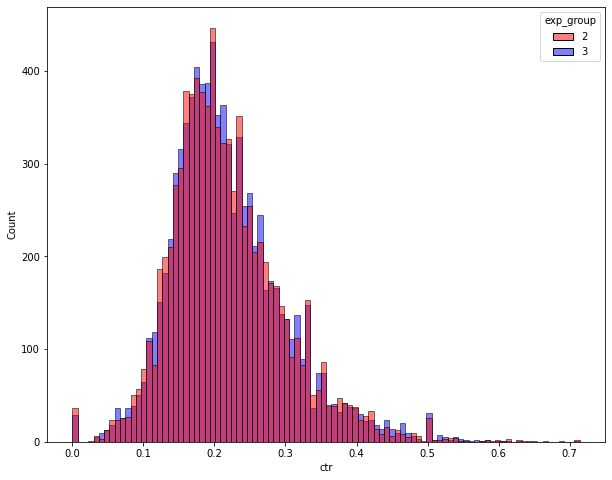

In [7]:
# смотрим распределение ctr в группах

plt.figure(figsize=(10, 8))
sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [17]:
# для удобства - сделаем отдельные датафреймы для групп, оставим в них только id и ctr
# группа 2
exp_group_2 = df[df.exp_group == 2][['user_id', 'ctr']]
exp_group_2.reset_index(drop=True, inplace=True)
exp_group_2

,user_id,ctr
0,131473,0.175676
1,23985,0.181818
2,24523,0.141667
3,24239,0.445378
4,14680,0.114286
...,...,...
8475,16512,0.132075
8476,17146,0.106667
8477,25383,0.280702
8478,108927,0.242424


In [18]:
# группа 3
exp_group_3 = df[df.exp_group == 3][['user_id', 'ctr']]
exp_group_3.reset_index(drop=True, inplace=True)
exp_group_3

,user_id,ctr
0,115383,0.305556
1,123580,0.163043
2,19647,0.143836
3,107670,0.217391
4,126702,0.250000
...,...,...
8564,122758,0.174528
8565,130651,0.280000
8566,13489,0.142857
8567,122008,0.129032


  0%|          | 0/10000 [00:00<?, ?it/s]

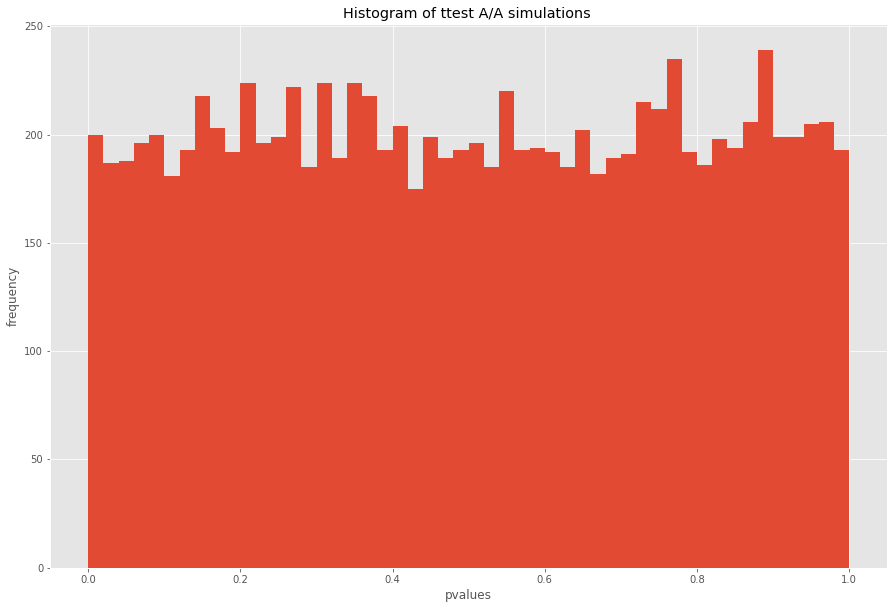

0.0477

In [20]:
# устанавливаем количество симуляций и размер подвыборок
simulations = 10000
n_s = 500
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = exp_group_2['ctr'].sample(n_s, replace = False).values
    s2 = exp_group_3['ctr'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])
    
plt.figure(figsize=(15, 10))
plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, какой процент p-values оказался меньше либо равен 0.05
sum(np.array(res) <= 0.05) / simulations

Доля ложноположительных оценок меньше уровня альфа (FPR <= 0.05). Система сплитования работает корректно.